<a href="https://colab.research.google.com/github/milanazhang/data-course-sample/blob/main/content-based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content=based Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-30 19:56:59--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.2’

All_Beauty.csv.2    100%[===================>]  14.78M  23.5MB/s    in 0.6s    

2021-12-30 19:57:00 (23.5 MB/s) - ‘All_Beauty.csv.2’ saved [15499476/15499476]

--2021-12-30 19:57:00--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.2’

meta_All_Beauty.jso 100%[===================>]   9.85M  18.6MB/s    in 0.5s   

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [4]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [6]:
import numpy as np
import re

In [7]:
#將資料裡空list換成np.NaN，統計每個欄位有多少空值
metadata.head()
metadata_fillna = metadata.mask(metadata.applymap(str).eq('[]'))
metadata_fillna = metadata_fillna.replace('',np.NaN)
metadata_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32892 entries, 0 to 32891
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         0 non-null      float64
 1   tech1            10 non-null     object 
 2   description      15119 non-null  object 
 3   fit              0 non-null      float64
 4   title            32891 non-null  object 
 5   also_buy         6597 non-null   object 
 6   tech2            0 non-null      float64
 7   brand            17219 non-null  object 
 8   feature          269 non-null    object 
 9   rank             32515 non-null  object 
 10  also_view        8132 non-null   object 
 11  details          32892 non-null  object 
 12  main_cat         32892 non-null  object 
 13  similar_item     1304 non-null   object 
 14  date             19 non-null     object 
 15  price            11459 non-null  object 
 16  asin             32892 non-null  object 
 17  imageURL    

In [8]:
#移除資料裡有重複的部分，保留不重複的資料的index
metadata_fillna=metadata_fillna.astype('str')
metadata_fillna.drop_duplicates(inplace=True)
remain_index = metadata_fillna.index

In [9]:
#挑選需要欄位與資料與整理欄位內的特殊符號
metadata_df = metadata.iloc[list(remain_index)][["asin","also_buy","also_view","rank","similar_item","price","brand","description","title","details"]]
metadata_df = metadata_df.replace(r'^\s*$', np.NaN, regex = True)

In [10]:
#將rank分成排名與商品子集
metadata_df['rank'] = metadata_df['rank'].str.replace(',', '')
metadata_df['sub_cat'] = metadata_df['rank'].str.extract(r'(\d+) in (.*) \($')[1].str.replace('&amp;','&')
metadata_df['rank_num'] = pd.to_numeric(metadata_df['rank'].str.extract(r'(\d+) in (.*) \($')[0])
metadata_df = metadata_df.drop("rank",axis=1)

In [11]:
#將similar_item從字串擷取出來
metadata_df["similar_item"] = metadata_df["similar_item"].apply(lambda x : [i[1] for i in re.findall(r'(/dp/)(.*)(/ref=)',x)] if isinstance(x,str) else np.NaN)

In [12]:
#將price的數字擷取出來
metadata_df["price"] = metadata_df["price"].str.replace(',','').str.extract(r'^(\$)(.+)$')[1]
metadata_df["price"] = metadata_df["price"].fillna("-").apply(lambda x: x if '-' not in x else np.NaN)
metadata_df["price"] = metadata_df["price"].astype("float")

In [11]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## Text Normalization

In [14]:
!pip install nltk

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix, hstack

In [16]:
# check punctuation
from string import punctuation
# check stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
# define functions for text preocessing
import string
# remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))
# remove stop words
def remove_stopwords(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop_words])
    return x
# lowercase
def to_lower(x):
    return x.lower()
# stem the words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
metadata_df["title"] = metadata_df["title"].fillna("").apply(porter.stem)
metadata_df["title"] = metadata_df["title"].apply(remove_punctuation).apply(remove_stopwords).apply(to_lower)
metadata_df["brand"] = metadata_df["brand"].fillna("").apply(remove_punctuation).apply(remove_stopwords).apply(to_lower)
metadata_df["description"] = metadata_df["description"].apply(lambda x : " ".join(x)).fillna("").apply(porter.stem)
metadata_df["description"] = metadata_df["description"].apply(remove_punctuation).apply(remove_stopwords).apply(to_lower)

In [18]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
text1 = metadata_df["title"][0]
tokens = word_tokenize("")
print(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[]


In [19]:
# apply countVectorize to title, description
cv = CountVectorizer(min_df=10)
x_title = cv.fit_transform(metadata_df['title'])
x_description = cv.fit_transform(metadata_df['description'])

In [20]:
print("Item title Shape: " + str(x_title.shape))
print("description Shape: " + str(x_description.shape))

Item title Shape: (32488, 4157)
description Shape: (32488, 6572)


In [21]:
# apply LabelBinarizer to brand
lb = LabelBinarizer(sparse_output=True)
x_brand = lb.fit_transform(metadata_df["brand"])
print("Item Brand Shape: " + str(x_brand.shape))
print(x_brand)

Item Brand Shape: (32488, 7556)
  (0, 3245)	1
  (1, 0)	1
  (2, 4847)	1
  (3, 0)	1
  (4, 5359)	1
  (5, 4258)	1
  (6, 0)	1
  (7, 1289)	1
  (8, 6408)	1
  (9, 6515)	1
  (10, 2220)	1
  (11, 3040)	1
  (12, 0)	1
  (13, 5121)	1
  (14, 286)	1
  (15, 3040)	1
  (16, 0)	1
  (17, 1337)	1
  (18, 2474)	1
  (19, 6084)	1
  (20, 3450)	1
  (21, 0)	1
  (22, 4860)	1
  (23, 4860)	1
  (24, 0)	1
  :	:
  (32463, 0)	1
  (32464, 832)	1
  (32465, 0)	1
  (32466, 1711)	1
  (32467, 0)	1
  (32468, 7453)	1
  (32469, 1461)	1
  (32470, 838)	1
  (32471, 0)	1
  (32472, 0)	1
  (32473, 1755)	1
  (32474, 498)	1
  (32475, 2690)	1
  (32476, 2690)	1
  (32477, 0)	1
  (32478, 0)	1
  (32479, 0)	1
  (32480, 7483)	1
  (32481, 0)	1
  (32482, 783)	1
  (32483, 0)	1
  (32484, 5880)	1
  (32485, 0)	1
  (32486, 2667)	1
  (32487, 0)	1


In [114]:
lb.classes_

array(['', ' hair', ' usa inc', ..., 'zyliss', 'zytaze', 'zzzrt traders'],
      dtype='<U85')

In [22]:
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
x_title = tv.fit_transform(metadata_df['title'])
print("Item title Shape: " + str(x_title.shape))

Item title Shape: (32488, 55000)


In [23]:
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']
# Lowest TFIDF Scores
print(tfidf.sort_values(by=['tfidf'], ascending=True).head(10))
# Highest TFIDF Scores
print(tfidf.sort_values(by=['tfidf'], ascending=False).head(10))

          tfidf
oz     2.913954
pack   3.220454
hair   3.415846
amp    3.436042
set    3.678900
black  3.776320
body   3.831184
nail   3.911618
color  4.086160
cream  4.092922
                        tfidf
mini fpv             10.69551
portable automotive  10.69551
oligopeptide         10.69551
olight m22           10.69551
olight               10.69551
olie biologique      10.69551
portable brush       10.69551
olie                 10.69551
portable carry       10.69551
oliadesignreg set    10.69551


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
sparse_merge = hstack((x_brand, x_title)).tocsr()

In [132]:
x_title.shape

(32488, 55000)

# EDA

## metadata

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Beauty & Personal Care 32015
nan 402
Grocery & Gourmet Food 37
Health & Household 21
Sports & Outdoors 3
Toys & Games 3
Baby 2
Clothing Shoes & Jewelry 2
Home & Kitchen 1
Automotive 1
Tools & Home Improvement 1


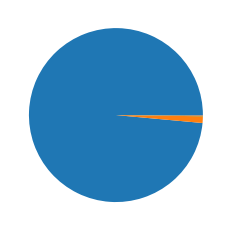

In [15]:
#統計商品子集有多少種及各種所佔的數量(不用main_cat的原因為，所有資料的main_cat都是一樣的)
rank_dict = {}
for i in metadata_df['sub_cat'].to_list():
  if rank_dict.get(i) != None:
    rank_dict[i] += 1
  else:
    rank_dict[i] = 1
for key in rank_dict.keys():
  print(key,rank_dict[key])

plt.pie(rank_dict.values())
plt.show()

('ASIN', 32381)
('Shipping Weight', 19779)
('UPC', 15377)
('Item model number', 5483)
('Product Dimensions', 5218)
('Item Weight', 3476)
('Domestic Shipping', 1328)
('International Shipping', 1328)
('Discontinued by manufacturer', 257)
('Batteries', 87)
('Shipping Advisory', 7)


<BarContainer object of 11 artists>

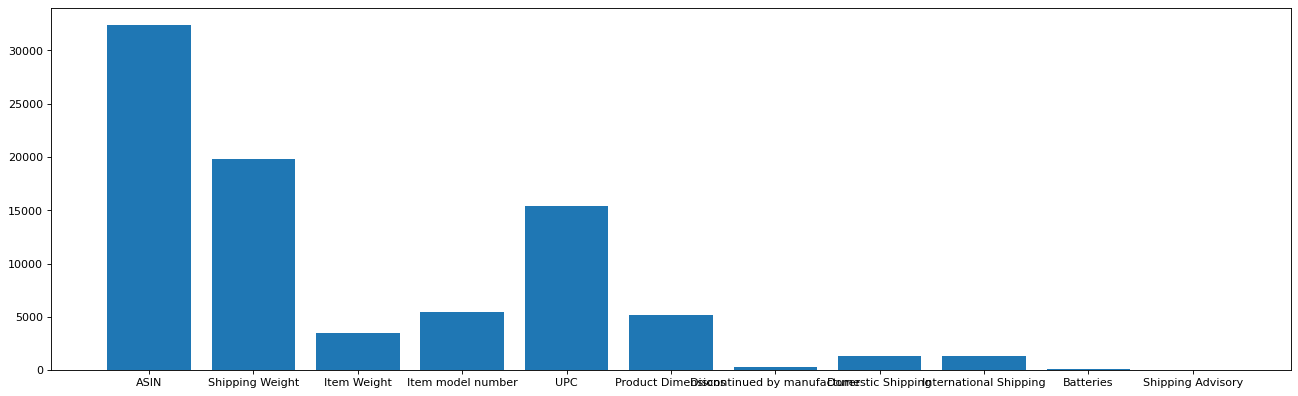

In [16]:
#統計商品的detail裡面有多少種資訊及各種所佔的數量
detail_key = {}
for index,row in metadata_df[["details"]].iterrows():
  for k in row['details'].keys():
    r_k = re.sub(r'\n    ','',k).strip(" ").strip(":")
    if detail_key.get(r_k) != None:
      detail_key[r_k] += 1
    else:
      detail_key[r_k] = 1
for k in sorted(detail_key.items(),key=lambda x : x[1],reverse=True):
  print(k)

plt.figure(figsize=(20, 6), dpi=80)
plt.bar(x=detail_key.keys(),height=detail_key.values())

In [17]:
#ratings中有不存在在metadata的商品，共100個，推薦時可能要加以排除
rating_asin_set = set(ratings["asin"].to_list())
all_asin_set = set(metadata_df["asin"].to_list())
print(len(rating_asin_set - all_asin_set))

100


In [18]:
#商品的價格分布大都集中在$60以下
fig = px.box(metadata_df, x = "sub_cat", y="price")
fig.show()

In [19]:
#大部分brand都只有1-2種商品
brand_key = {}
for k in metadata_df[metadata_df["brand"].notna()]["brand"].to_list():
  if brand_key.get(k) != None:
    brand_key[k] += 1
  else:
    brand_key[k] = 1
tmp_df = pd.DataFrame({"product_num":list(brand_key.values())})
fig = px.box(tmp_df, y="product_num")
fig.show()

## ratings

In [20]:
ratings["year"] = ratings["DATE"].astype(str).str.extract("(\d\d\d\d)-(\d\d)-(\d\d)")[0]
ratings["month"] = ratings["DATE"].astype(str).str.extract("(\d\d\d\d)-(\d\d)-(\d\d)")[1]
ratings["day"] = ratings["DATE"].astype(str).str.extract("(\d\d\d\d)-(\d\d)-(\d\d)")[2]

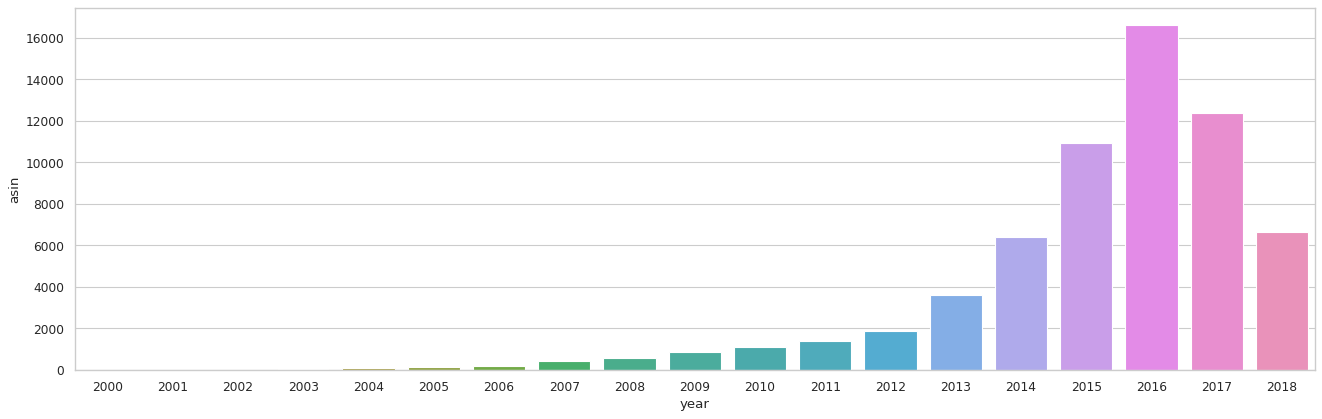

In [21]:
tmp_df = ratings.groupby("year").nunique("asin").reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6), dpi=80)
ax = sns.barplot(x="year", y="asin", data=tmp_df)

In [22]:
convert_rating = ratings.pivot_table(values='day', index="asin", columns='year', aggfunc='count').fillna(0)

In [ ]:
for i in range(2000,2019):
  str(i)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


## 資料切分

In [12]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

In [13]:
metadata_df["title"]

NameError: ignored

## 產生推薦

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題所表示的 tfidf 矩陣
df = metadata_df.drop_duplicates('title')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title'])

# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df['title'])

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res


NameError: ignored

In [14]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    recommendations = {user: recommend_items(metadata[metadata['asin'].isin(ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist())]['title'].tolist(), k) for user in users}
    return recommendations

ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00AU92V44',
  'B014HILES2',
  'B01DPZJ6JM',
  'B01A6O5KUY',
  'B01CL3IXJI',
  'B008XNX92C',
  'B018OLOHVY',
  'B018OSUOC8',
  'B000QPXD26',
  'B00DG8Q9KS'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B016Y5KOAA',
  'B016Y

## 結果評估

In [15]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0